In [61]:
import numpy as np 
import pandas as pd 
import cv2 
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image

import os
print(os.listdir("C:\\Users\\Bipasha\\Face_dataset/"))


['data', 'train', 'val']


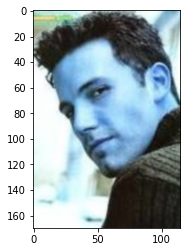

(170, 115, 3)


In [62]:
img = cv2.imread('C:\\Users\\Bipasha\\Face_dataset\\data\\train\\ben_afflek\\httpcsvkmeuaeccjpg.jpg')
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.show()
print(img.shape)

# Extract a single face from a given photograph

In [63]:
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)   
    image = image.convert('RGB')    
    pixels = np.asarray(image)
    detector = MTCNN()    
    results = detector.detect_faces(pixels)   
    x1, y1, width, height = results[0]['box']    
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height   
    face = pixels[y1:y2, x1:x2]   
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

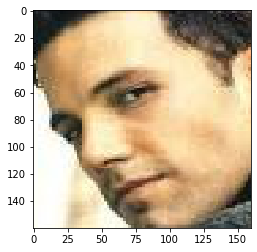

(160, 160, 3)


In [64]:
pixels = extract_face('C:\\Users\\Bipasha\\Face_dataset\\data\\train\\ben_afflek\\httpcsvkmeuaeccjpg.jpg')
plt.imshow(pixels)
plt.show()
print(pixels.shape)

In [65]:
def load_face(dir):
    faces = list()    
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path)
        faces.append(face)
    return faces

def load_dataset(dir):    
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

In [66]:
trainX, trainy = load_dataset('C:\\Users\\Bipasha\\Face_dataset\\data\\train/')
print(trainX.shape, trainy.shape)

testX, testy = load_dataset('C:\\Users\\Bipasha\\Face_dataset\\data\\val/')
print(testX.shape, testy.shape)


np.savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

loaded 14 sample for class: ben_afflek
loaded 17 sample for class: elton_john
loaded 21 sample for class: jerry_seinfeld
loaded 19 sample for class: madonna
loaded 22 sample for class: mindy_kaling
(93, 160, 160, 3) (93,)
loaded 5 sample for class: ben_afflek
loaded 5 sample for class: elton_john
loaded 5 sample for class: jerry_seinfeld
loaded 5 sample for class: madonna
loaded 5 sample for class: mindy_kaling
(25, 160, 160, 3) (25,)


In [67]:
data = np.load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


In [68]:
from keras.models import load_model
facenet_model = load_model('facenet_keras.h5')
print('loaded_model')


loaded_model


C:\Users\Bipasha\Anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [69]:
def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.predict(sample)
    return yhat[0]
    
# convert each face in the train set into embedding
emdTrainX = list()
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

# convert each face in the test set into embedding
emdTestX = list()
for face in testX:
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)


np.savez_compressed('5-celebrity-faces-embeddings.npz', emdTrainX, trainy, emdTestX, testy)

(93, 128)
(25, 128)


In [70]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))


# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)


# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)


# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)

# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)

print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=93, test=25
Accuracy: train=100.000, test=100.000


Predicted: 
['ben_afflek' 'elton_john' 'jerry_seinfeld' 'madonna' 'mindy_kaling'] 
[ 2.57787227  4.11031737  1.06817821 87.64729187  4.59634028]
Expected: madonna


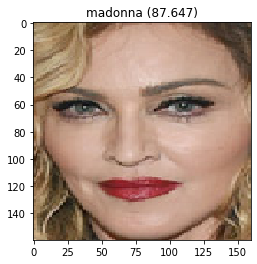

In [71]:
from random import choice

selection = choice([i for i in range(testX.shape[0])])
random_face = testX[selection]
random_face_emd = emdTestX_norm[selection]
random_face_class = testy_enc[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)


# get name

class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2,3,4])


print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
print('Expected: %s' % random_face_name[0])



plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()